In [52]:
import numpy as np
import pandas as pd
import pylab as plt
import math
%matplotlib inline

In [53]:
train_X = pd.read_csv('train_X.csv').set_index('id')
train_y = pd.read_csv('train_y.csv').set_index('id')
validate_X = pd.read_csv('validate_X.csv').set_index('id')
validate_y = pd.read_csv('validate_y.csv').set_index('id')
X = pd.read_csv('train_X_full.csv').set_index('id')
y = pd.read_csv('train_y_full.csv').set_index('id')
test_X = pd.read_csv('test_X.csv').set_index('id')

Между обновлением вектора весов по всей выборке и на одном объекте есть промежуточный подход — выбирать некоторое случайное подмножество объектов и обновлять веса по нему. Такой подход называется mini-batch. Мы не будем реализовывать этот подход в данной работе, однако иногда его бывает осмысленно использовать на практике. 

Один из недостатков sgd состоит в том, что он может не доходить до локального оптимального решения, а осциллировать в окрестности. 

Для решения этой проблемы существуют методы, позволяющие устранить этот недостаток, а также ускорить сходимость. Рассмотрим некоторые из них.

### Momentum

Этот метод позволяет направить sgd в нужной размерности и уменьшить осцилляцию. 

В общем случае он будет выглядеть следующим образом: 

$$ v_t = \gamma v_{t - 1} + \eta \nabla_{\theta}{J(\theta)}$$
$$ \theta = \theta - v_t$$

где

 - $\theta$ — вектор параметров (в нашем случае — $w$)
 - $J$ — оптимизируемый функционал
 - $\gamma$ — momentum term (обычно выбирается 0.9)
 
### Adagrad 

Одной из сложностей является выбор размера шага (*learning rate*). Основное отличие данного метода от SGD состоит в том что размер шага определяется для каждого параметра индивидуально. Этот метод хорошо работает с разреженным данным большого объема. 

Обозначим градиент по параметру $\theta_i$ на итерации $t$ как $g_{t,i} = \nabla_{\theta}J(\theta_i)$. 

В случае sgd обновление параметра $\theta_i$ будет выглядеть следующим образом:

$$ \theta_{t+1, i} = \theta_{t, i} - \eta \cdot g_{t,i}$$

А в случае Adagrad общий шаг $\eta$ нормируется на посчитанные ранее градиенты для данного параметра:

$$ \theta_{t+1, i} = \theta_{t, i} - \dfrac{\eta}{\sqrt{G_{t,ii} + \varepsilon}} \cdot g_{t,i}$$

где $G_t$ — диагональная матрица, где каждый диагональный элемент $i,i$ — сумма квадратов градиентов для $\theta_{i}$ до $t$-ой итерации. $\varepsilon$ — гиперпараметр, позволяющий избежать деления на 0 (обычно выбирается около *1e-8*).

Так как матрица $G_t$ диагональна, в векторном виде это будет выглядеть следующим образом (здесь $\odot$ — матричное умножение):

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{G_t + \varepsilon}} \odot g_t $$

### Adadelta

Adadelta, в отличии от Adagrad, рассматривает не все предыдущие значения градиентов, а только последние $k$. Кроме того, сумма градиентов определяется как уменьшающееся среднеее всех предыдущих квадратов градиентов. Текущее среднее $E[g^2]_t$ на итерации $t$ будет вглядеть следующим образом:

$$ E[g^2]_t = \gamma E[g^2]_{t-1} + (1-\gamma)g_t^2 $$

здесь $\gamma$ аналогична гиперпараметру из метода Momentum.

Тогда обновление весов можно записать следующим образом:

$$ \theta_{t+1} = \theta_{t} - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Перепишем это немного по-другому:

$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 
$$\Delta \theta_t = - \dfrac{\eta}{\sqrt{E[g^2]_t + \varepsilon}} g_t $$ 

Аналогично среднему для градиентов определим среднее для параметров $\theta$:

$$ E[\Delta \theta^2]_t = \gamma E[\Delta \theta^2]_{t-1} + (1-\gamma)\Delta \theta^2 $$

Введем обозначение $RMS[p]_t = \sqrt{E[p]_t + \varepsilon}$

Тогда Adadelta выглядит следующим образом:

$$\Delta \theta_t = - \dfrac{RMS[\Delta \theta^2]}{RMS[ga^2]} g_t $$ 
$$ \theta_{t+1} = \theta_{t} + \Delta \theta_t$$ 


Более подробно об этих и других способах оптимизации можно прочитать:
 - [здесь](http://sebastianruder.com/optimizing-gradient-descent/index.html#gradientdescentoptimizationalgorithms) очень хорошее описание различных способов оптимизации, в этом задании мы опираемся на терминологию из данной статьи
 - статья про [momentum](https://pdfs.semanticscholar.org/97da/c94ffd7a7ac09a4218848300cc7e98569d77.pdf)
 - оригинальная статья про [adagrad](http://www.jmlr.org/papers/volume12/duchi11a/duchi11a.pdf)
 - оригинальная статья про [adadelta](http://arxiv.org/pdf/1212.5701v1.pdf)
 - википедия про [momentum](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#Momentum) и [adagrad](https://en.wikipedia.org/wiki/Stochastic_gradient_descent#AdaGrad)
 - [визуализация](http://imgur.com/a/Hqolp) разных способов оптимизации

### Задание

Реализуйте метод оптимизации *Momentum* **(0.5 балла)** и один из *Adagrad*/*Adadelta* **(1 балл)**.
- Сравните оба метода с классическим sgd с точки зрения скорости сходимости.
- Посмотрите как значение гиперпараметра $\gamma$ влияет на скорость сходимости и качество в методе *Momentum*.

В заданиях выше требуется построить графики и описать полученные результаты.

Дало ли преимущество использование адаптивного шага в методе *Adagrad*/*Adadelta*?

### Momentum

In [88]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
import random

# не работает при параллельном запуске
from scipy.special import expit

# def expit(x):
#     return 1 / (1 + np.exp(-x))

class MyClassifierMomentum(BaseEstimator, ClassifierMixin):
    loss_functions = {
        "log": (log_loss,),
    }

    def __init__(
            self,
            loss='log',
            penalty='l2',
            max_iter=10000,
            tol=1e-4,
            learning_rate='const',
            eta0=1,
            w=None,
            verbose=0,
            C=0,
            n_iter_no_change=1,
            momentum_term=0.9,
    ):
        self.loss = loss
        self.loss_func = loss
        self.penalty = penalty
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.eta0 = eta0
        self.verbose = verbose
        self.C = C
        self.n_iter_no_change = n_iter_no_change
        self.momentum_term = momentum_term

        self.u = 0
        self.w = w
        self.iter = 0
        self.eta = 0
        self.iter_total = 0
        self.coef_ = None
        self.iter_error = []
        self.error = None

    def get_loss_func(self):
        return MyClassifier.loss_functions[self.loss_func][0]

    def fit(self, _X, _y):
        X = np.array(_X)
        y = np.array(_y)

        if self.w is None:
            self.coef_ = np.zeros((X.shape[1], 1))
        else:
            self.coef_ = self.w.copy()

        # Добавляем ещё один признак который будет заменять регуляризатор b
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1) * y

        # Сохраняем начальную инициализацию весов
        self.coef_ = np.append(np.zeros((1, 1)), self.coef_, axis=0)

        coef = self.coef_
        coef_norm = np.linalg.norm(coef)
        no_change = self.n_iter_no_change

        for i in range(self.max_iter):
            nu = self.get_learning_rate(i)
            error = self.error_calc(X, y, coef)
            
            if error == np.inf:
                break
            
            if self.verbose > 1:
                self.iter_error.append([i, error])
                
            coef, u = self.next_iter(coef, self.u, X, y, nu, self.momentum_term)
            coef_new_norm = np.linalg.norm(coef)
            
            if abs(coef_norm - coef_new_norm) < self.tol:
                if no_change == 1:
                    break
                else:
                    no_change -= 1
            else:
                no_change = self.n_iter_no_change
            
            self.coef_ = coef
            self.u = u
            coef_norm = coef_new_norm

        self.iter_total = i
        self.error = self.error_calc(X, y, coef)

        if self.verbose:
            print('iter total:', self.iter_total)

        return self

    def get_learning_rate(self, n_iter):
        if self.learning_rate == 'const':
            return self.eta0

    def prob(self, X, w):
        prob = expit(X @ w)
        return np.hstack([1 - prob, prob])
    
    def error_calc(self, X, y, w):
        N = X.shape[0]
        return np.sum(np.log(1 + np.exp(-X @ w))) / N

    def loss_calc(self, X, y, w):
        prob = self.prob(X, w)
        return self.get_loss_func()(y, prob)

    def next_iter(self, w, u, X, y, nu, momentum_term):
        N = X.shape[0]
        next_i = random.randrange(0, N)
        row = X[next_i:next_i + 1]
        gradient_matrix = row.T @ (1 - expit(row @ w))
        u_new = momentum_term * u - nu * gradient_matrix
        w_new = w - u_new

        return w_new, u_new

    def predict_proba(self, _X):
        X = _X.copy()
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        prob = self.prob(X, self.coef_)
        return prob

In [317]:
clf = MyClassifierMomentum(max_iter=10000, verbose=2, learning_rate='const', eta0=0.004, momentum_term=0, n_iter_no_change=5)
clf.fit(train_X, train_y)
clf.error

iter total: 9999


0.23610790977284649

In [95]:
res = []
for mom in np.arange(0.1, 1, 0.1):
    mom = math.floor(mom * 1000) / 1000
    clf = MyClassifierMomentum(max_iter=10000, verbose=0, learning_rate='const', eta0=0.11, tol=1e-6, momentum_term=mom)
    clf.fit(train_X, train_y)
    res.append([mom, clf.iter_total, clf.error])
df_iter_momentum = pd.DataFrame(res, columns=['momentum','iter', 'error'])

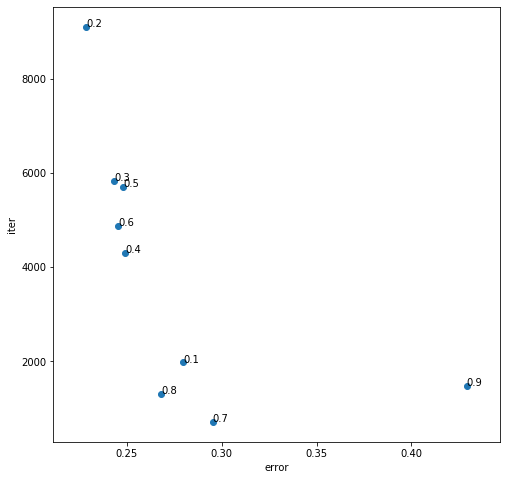

In [96]:
df = df_iter_momentum
plt.figure(figsize=(8, 8))
plt.scatter(df['error'], df['iter'])
plt.xlabel('error')
plt.ylabel('iter')
for i, x in df.iterrows(): 
    plt.annotate(x['momentum'], (x['error'], x['iter']))

Чтобы получить приемлемое качество удалось спуститься ниже максимального количества итераций, так что можно считать что метод ускоряет сходимость

### Adagrad

In [304]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import log_loss
import random

from scipy.special import expit

class MyClassifierAdgard(BaseEstimator, ClassifierMixin):
    loss_functions = {
        "log": (log_loss,),
    }

    def __init__(
            self,
            loss='log',
            penalty='l2',
            max_iter=10000,
            tol=1e-4,
            learning_rate='const',
            eta0=1,
            w=None,
            verbose=0,
            C=0,
            n_iter_no_change=5,
            eps=1e-8,
    ):
        self.loss = loss
        self.loss_func = loss
        self.penalty = penalty
        self.max_iter = max_iter
        self.tol = tol
        self.learning_rate = learning_rate
        self.eta0 = eta0
        self.verbose = verbose
        self.C = C
        self.n_iter_no_change = n_iter_no_change
        self.eps = eps

        self.coeff_sum = None
        self.w = w
        self.iter = 0
        self.eta = 0
        self.iter_total = 0
        self.coef_ = None
        self.iter_error = []
        self.error = None
        self.coef_sum = 0

    def get_loss_func(self):
        return MyClassifier.loss_functions[self.loss_func][0]

    def fit(self, _X, _y):
        X = np.array(_X)
        y = np.array(_y)

        if self.w is None:
            self.coef_ = np.zeros((X.shape[1], 1))
        else:
            self.coef_ = self.w.copy()

        # Добавляем ещё один признак который будет заменять регуляризатор b
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1) * y

        # Сохраняем начальную инициализацию весов
        self.coef_ = np.append(np.zeros((1, 1)), self.coef_, axis=0)
        coef_sum = self.coef_.copy()

        coef = self.coef_ * self.coef_
        coef_norm = np.linalg.norm(coef)
        no_change = self.n_iter_no_change

        for i in range(self.max_iter):
            nu = self.get_learning_rate(i)
            error = self.error_calc(X, y, coef)
            
            if error == np.inf:
                break
            
            if self.verbose > 1:
                self.iter_error.append([i, error])
                
            coef = self.next_iter(coef, X, y, nu, self.eps, coef_sum)
            coef_new_norm = np.linalg.norm(coef)
            
            if abs(coef_norm - coef_new_norm) < self.tol:
                if no_change == 1:
                    break
                else:
                    no_change -= 1
            else:
                no_change = self.n_iter_no_change
            
            self.coef_ = coef
            coef_sum += coef * coef
            coef_norm = coef_new_norm

        self.iter_total = i
        self.error = self.error_calc(X, y, coef)
        self.coef_sum = coef_sum

        return self

    def get_learning_rate(self, n_iter):
        if self.learning_rate == 'const':
            return self.eta0

    def prob(self, X, w):
        prob = expit(X @ w)
        return np.hstack([1 - prob, prob])
    
    def error_calc(self, X, y, w):
        N = X.shape[0]
        return np.sum(np.log(1 + np.exp(-X @ w))) / N

    def loss_calc(self, X, y, w):
        prob = self.prob(X, w)
        return self.get_loss_func()(y, prob)

    def next_iter(self, w, X, y, nu, eps, coef_sum):
        N = X.shape[0]
        next_i = random.randrange(0, N)
        row = X[next_i:next_i + 1]
        gradient_matrix = row.T @ (1 - expit(row @ w))
        g = np.sqrt(coef_sum + eps)
        w_new = w + nu * gradient_matrix / g

        return w_new

    def predict_proba(self, _X):
        X = _X.copy()
        X = np.append(np.ones((X.shape[0], 1)), X, axis=1)
        prob = self.prob(X, self.coef_)
        return prob

Попробуем подобрать гиперпараметр eps и посмотреть ошибку алгоритма

In [311]:
res = []
clfs = []
for eps in np.geomspace(1e-4, 1, num=20):
    clf = MyClassifierAdgard(max_iter=10000, verbose=2, learning_rate='const', eta0=4e-3, tol=1e-4, eps=eps, n_iter_no_change=5)
    clf.fit(train_X, train_y)
    clfs.append(clf)
    res.append([eps, clf.iter_total, clf.error])
    
df_iter_adgard = pd.DataFrame(res, columns=['eps','iter', 'error'])

Посмотрим на результаты

In [312]:
df_iter_adgard.describe()

eps        iter      error
count  20.000000    20.00000  20.000000
mean    0.130149  2838.95000   0.574346
std     0.258765  1645.28041   0.192034
min     0.000100   304.00000   0.454646
25%     0.001020  1511.50000   0.473958
50%     0.010295  2602.00000   0.491445
75%     0.102401  4209.25000   0.609567
max     1.000000  5380.00000   1.265752

Text(0, 0.5, 'error')

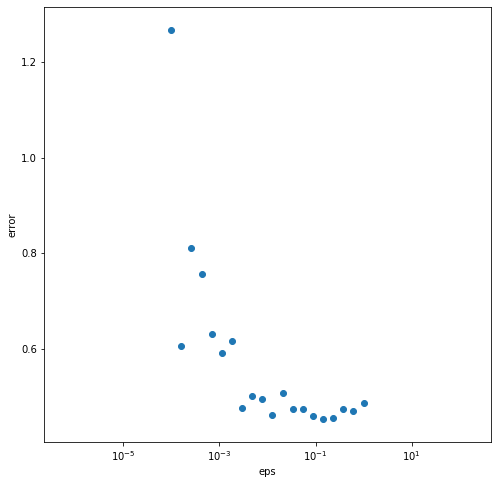

In [314]:
df = df_iter_adgard
plt.figure(figsize=(8, 8))
plt.xscale('log')
plt.scatter(df['eps'], df['error'])
plt.xlabel('eps')
plt.ylabel('error')

Видим, что метод так же дает лучшую сходимость, однако ошибка оказывается значительно выше стандартного решения sgd